# [これ](https://mori-memo.hateblo.jp/entry/2022/10/16/173011)見てやり直すか...

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# ディレクトリの移動
%cd /content/drive/MyDrive/nlp100
%pwd
!ls
%cd ./nlp100/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/nlp100


'/content/drive/MyDrive/nlp100'

In [2]:
import gc

gc.enable()
print(gc.isenabled)

<built-in function isenabled>


In [3]:
CATEGORY_DICT = {"b" : 0, "t" : 1, "e": 2, "m" : 3}
CUT_THRESHOLD_FOR_MEMORY = 500
SHUFFLE = False

## 80. ID番号への変換
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [4]:
# 問題51ではtfidfを使ったのに対して、ここで要求されていることが割と違うため、データを作り直す
import pandas as pd
from collections import defaultdict
import re

df_train = pd.read_csv("./NewsAggregatorDataset/train.csv", sep="\t")
df_valid = pd.read_csv("./NewsAggregatorDataset/valid.csv", sep="\t")
df_test = pd.read_csv("./NewsAggregatorDataset/test.csv", sep="\t")

# 前処理
def preprocessing(text):
    text_clean = re.sub(r'[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]', '', text)
    text_clean = re.sub('[0-9]+', '0', text_clean)
    text_clean = re.sub('\s-\s', ' ', text_clean)
    return text_clean

df_train["TITLE"] = df_train["TITLE"].apply(preprocessing)
df_valid["TITLE"] = df_valid["TITLE"].apply(preprocessing)
df_test["TITLE"] = df_test["TITLE"].apply(preprocessing)

titles_train = df_train["TITLE"]
titles_valid = df_valid["TITLE"]
titles_test = df_test["TITLE"]

CUT_THRESHOLD_FOR_MEMORY = len(titles_train)

titles_train = titles_train[:CUT_THRESHOLD_FOR_MEMORY]

word_count_dict_train = defaultdict(int)
for title in titles_train:
    title_word_list = title.split()
    for word in title_word_list:
        word_count_dict_train[word] += 1
print(word_count_dict_train)

sorted_word_count_dict = sorted(word_count_dict_train.items(), key=lambda x: x[1],reverse=True)
print(sorted_word_count_dict)

word_count_dict_valid = defaultdict(int)
for title in titles_valid:
    title_word_list = title.split()
    for word in title_word_list:
        word_count_dict_valid[word] += 1
print(word_count_dict_valid)

sorted_word_count_dict_valid = sorted(word_count_dict_valid.items(), key=lambda x: x[1],reverse=True)
print(sorted_word_count_dict_valid)

word_rank_dict = defaultdict(int)
for index, content in enumerate(sorted_word_count_dict):
    if content[1] < 2: #2回未満の単語のidはすべて0とする
        word_rank_dict[content[0]] = 0
    else:
        word_rank_dict[content[0]] = index+1
print(word_rank_dict)

# word_rank_dict_valid = defaultdict(int)
# for index, content in enumerate(sorted_word_count_dict_valid):
#     if content[1] < 2: #2回未満の単語のidはすべて0とする
#         word_rank_dict_valid[content[0]] = 0
#     else:
#         word_rank_dict_valid[content[0]] = index+1
# print(word_rank_dict_valid)

defaultdict(<class 'int'>, {'David': 38, 'McNew': 1, 'via': 7, 'Getty': 4, 'Images': 5, 'Barclays': 28, 'Will': 126, 'Post': 7, 'Small': 4, 'Decline': 29, 'in': 1428, 'First-Quarter': 6, 'Profit': 63, '0': 2082, 'Euro': 79, 'Anxieties': 1, 'Wane': 1, 'as': 1027, 'Bunds': 2, 'Top': 43, 'Treasuries': 19, 'Spain': 8, 'Debt': 18, 'Rallies': 3, 'Etihad': 4, 'Airways': 8, 'New': 317, 'Plane': 13, 'Design': 8, 'Takes': 28, 'Luxury': 4, 'To': 725, 'Heights': 1, 'Neil': 28, 'deGrasse': 4, 'Tyson': 9, 'Talks': 45, 'Asteroids': 2, 'With': 401, '0-Year-Old': 8, 'Boy': 9, 'In': 495, 'Michigan': 8, 'US': 861, 'announces': 13, 'funding': 6, 'to': 2138, 'fight': 24, 'citrus': 1, 'greening': 1, 'disease': 10, 'Smartphone': 9, 'Industry': 17, 'Promises': 4, 'Kill': 7, 'Switch': 3, 'Reduce': 4, 'Thefts': 1, 'Comcast': 19, 'Turns': 12, 'Back': 35, 'Cord-Cutting': 1, 'Tide': 1, 'Adds': 13, 'Video': 71, 'Customers': 8, 'UK': 84, 'Services': 10, 'Grow': 7, 'More': 106, 'Than': 59, 'Forecast': 29, 'Employment

In [5]:
justin_idx = df_train[df_train["TITLE"].str.contains("Justin Bieber Under")].index.tolist()
print(justin_idx)

[301]


In [6]:
def words_to_ids(words):
    words = words.split()
    ids = [word_rank_dict[word] for word in words]
    return ids

In [7]:
# print(words_to_ids(titles_train[0]))
# print(words_to_ids(titles_train[1]))

## 81. RNNによる予測
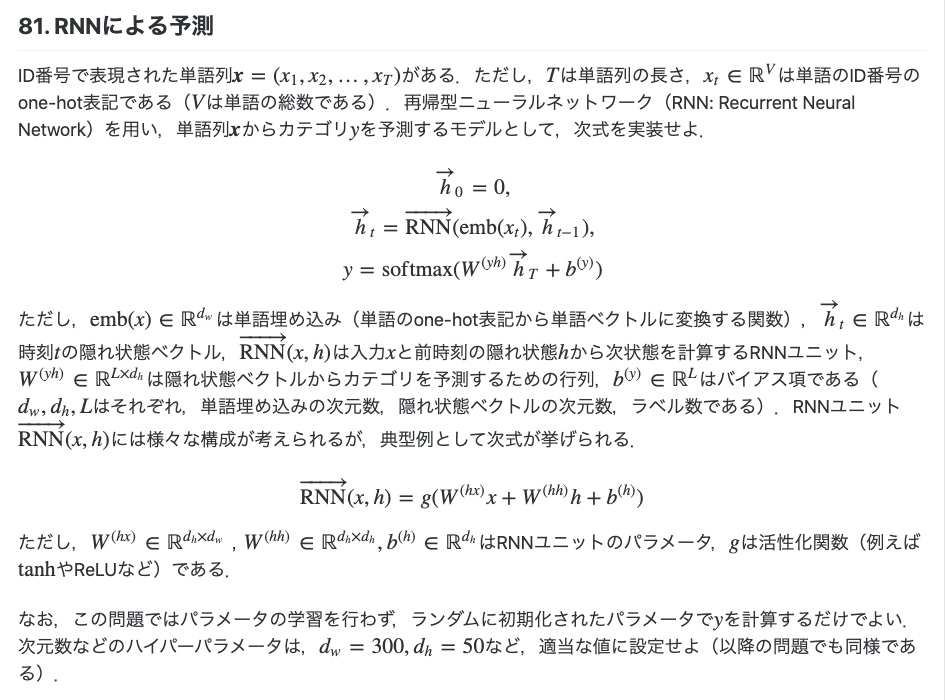

- 単語列からカテゴリを予測するRNNモデル
- $emb(x)$は単語埋め込み。単語のone-hotから単語ベクトルに変換する関数
    - $x_t$は「単語列」ではなく「単語（のID番号）」
    - $x_t$は単語のidのone-hot表記
        - one-hotにするのを諦めた...
        - $x_t$は単語idの配列とする。

In [8]:
import torch
from torch import nn, optim

MAX_ID = max(word_rank_dict.values())

dw = 300 #単語埋め込みの次元数
dh = 50 #隠れ常態ベクトルの次元数
LABEL_NUM = 4

max_length = max(len(lst) for lst in titles_train)
max_length_valid = max(len(lst) for lst in titles_train)

# print(max_length)

list_to_append = [0] * MAX_ID

titles_train_id_list = []
titles_valid_id_list = []

for title in titles_train:
    ids = words_to_ids(title)
    titles_train_id_list.append(ids)
for title in titles_valid:
    ids = words_to_ids(title)
    titles_valid_id_list.append(ids)

print(titles_train_id_list)
# 各リストの長さをmax_lengthに揃える
for i in range(len(titles_train)):
    while len(titles_train_id_list[i]) < max_length:
        titles_train_id_list[i].append(0)
for i in range(len(titles_valid)):
    while len(titles_valid_id_list[i]) < max_length_valid:
        titles_valid_id_list[i].append(0)

print("titles_train_id_list")
print(titles_train_id_list[301])
print(MAX_ID)



[[347, 0, 2515, 4098, 3431], [517, 55, 2516, 4099, 494, 3, 2911, 170, 2], [109, 0, 0, 5, 6567, 293, 853, 2213, 916, 5083], [4100, 2214, 25, 1324, 2215, 518, 4101, 11, 25, 0], [519, 4102, 1956, 267, 6568, 18, 2216, 1957, 14, 2217], [10, 1325, 2912, 1, 628, 0, 0, 1758], [1958, 977, 4103, 2517, 5084, 11, 4104, 0], [854, 1444, 388, 0, 0, 1326, 25, 135, 2218], [98, 1759, 2518, 70, 188, 495, 5, 6569, 4105, 64], [44, 45, 917, 568, 64, 52, 597, 4106, 1223, 1760], [2519, 3, 2913, 1959, 3432, 1327, 2914, 48, 121, 1593, 1, 13, 5085, 6570], [2219, 452, 795, 94, 49, 66, 520, 337, 21, 0, 4107], [233, 76, 148, 30, 1960, 1961, 404, 18, 205], [517, 6571, 4108, 1445, 1, 1761, 4109, 1594], [80, 31, 226, 0, 464, 89, 0, 2915, 1595, 6572, 12, 113], [268, 2916, 1130, 465, 193, 57, 598, 9, 13, 0, 4110], [2520, 0, 5086, 5087, 74, 1762, 6573], [6574, 2521, 242, 157, 253, 376], [10, 1763, 2, 1764, 1, 158, 23, 918, 46], [6, 569, 1962, 1765, 329, 1, 0, 754, 0], [151, 6575, 2220, 5084, 855, 92, 2, 663], [6, 0, 0, 2

In [9]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h0=None):
        # h0 = torch.zeros(1, x.size(0), self.hidden_size)
        x = self.emb(x)
        x, h = self.rnn(x, h0)
        x = x[:, -1, :]
        logits = self.fc(x)
        logits  =self.softmax(logits)
        return logits

## 82. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [10]:
BATCH_SIZE = 1

In [11]:
print(titles_train_id_list[94])

[4140, 4141, 1778, 4140, 4141, 423, 33, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
for one in titles_train_id_list:
    print(len(one))

ストリーミング出力は最後の 5000 行に切り捨てられました。
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
2390
239

In [13]:
import numpy as np

X_train = np.array(titles_train_id_list)
print(X_train)
print(type(X_train))
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(df_train["CATEGORY"].map(CATEGORY_DICT).tolist()[:CUT_THRESHOLD_FOR_MEMORY])
print(X_train.shape)
print(y_train.shape)
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2)

X_valid = np.array(titles_valid_id_list)
print(X_valid)
print(type(X_valid))
X_valid = torch.tensor(X_valid, dtype=torch.long)
y_valid = torch.tensor(df_valid["CATEGORY"].map(CATEGORY_DICT).tolist())
print(X_valid.shape)
print(y_valid.shape)
dataset_valid = torch.utils.data.TensorDataset(X_valid, y_valid)
dataloader_valid = torch.utils.data.DataLoader(dataset=dataset_valid, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2)

[[ 347    0 2515 ...    0    0    0]
 [ 517   55 2516 ...    0    0    0]
 [ 109    0    0 ...    0    0    0]
 ...
 [1121   11 4458 ...    0    0    0]
 [ 773 4844  242 ...    0    0    0]
 [1583    7    0 ...    0    0    0]]
<class 'numpy.ndarray'>
torch.Size([10672, 2390])
torch.Size([10672])
[[  43 2070    0 ...    0    0    0]
 [ 373    0  681 ...    0    0    0]
 [   8    0 3019 ...    0    0    0]
 ...
 [   0 7339  202 ...    0    0    0]
 [ 324 2339   23 ...    0    0    0]
 [   8  844   34 ...    0    0    0]]
<class 'numpy.ndarray'>
torch.Size([1334, 2390])
torch.Size([1334])


In [14]:
dataloader_dict = {"train" : dataloader_train, "valid" : dataloader_valid}

In [ ]:
from sklearn.metrics import accuracy_score

# パラメータの設定
# VOCAB_SIZE = MAX_ID + 2  # 辞書のID数 + unknown + パディングID
VOCAB_SIZE = MAX_ID + 2
EMB_SIZE = 300
PADDING_IDX = MAX_ID + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 100

EPOCH_NUM = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
optimizer = torch.optim.SGD(model.parameters(), 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

import matplotlib.pyplot as plt
from tqdm import tqdm

# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'valid']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return train_loss, train_acc, valid_loss, valid_acc

# 学習を実行する

# モデルの定義
net = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

num_epochs = 5
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloader_dict, criterion, optimizer, num_epochs=num_epochs)

# def train():
#     train_loss = 0
#     train_acc = 0
#     data_length = 0

#     y_true = []
#     y_pred = []
#     for idx, (x, y) in enumerate(dataloader_train):
#         optimizer.zero_grad()
#         data_length += 1
#         # print("=========")
#         # print("idx : {}".format(idx))
#         pred_logits = model(x)
#         loss = loss_fn(pred_logits, y)
#         pred_label = pred_logits.argmax(dim=1)
#         y_true.append(y.item())
#         y_pred.append(pred_label.item())
#         # print("y: {}, pred_label: {}".format(y, pred_label))
#         acc = accuracy_score(y, pred_label)
#         loss.backward()
#         train_loss += loss.item()
#         train_acc += acc #ここ書き直したい sklearnで
#         optimizer.step()

#     print("loss : {:>10}".format(train_loss / data_length))
#     print("accuracy : {:>10}".format(accuracy_score(y_true, y_pred)))
#     print("y_true : {}".format(y_true))
#     print("y_pred : {}".format(y_pred))

# for epoch in range(EPOCH_NUM):
#     print("========== epoch {}============".format(epoch+1))
#     train()

Epoch 1 / 5
--------------------------------------------


100%|██████████| 10672/10672 [51:45<00:00,  3.44it/s]


train Loss: 1.1827, Acc: 0.4122


100%|██████████| 1334/1334 [00:53<00:00, 25.11it/s]


valid Loss: 1.1685, Acc: 0.4235
Epoch 2 / 5
--------------------------------------------


100%|██████████| 10672/10672 [53:21<00:00,  3.33it/s]


train Loss: 1.1697, Acc: 0.4156


100%|██████████| 1334/1334 [00:52<00:00, 25.59it/s]


valid Loss: 1.1665, Acc: 0.4235
Epoch 3 / 5
--------------------------------------------


100%|██████████| 10672/10672 [53:07<00:00,  3.35it/s]


train Loss: 1.1676, Acc: 0.4139


100%|██████████| 1334/1334 [00:53<00:00, 24.94it/s]


valid Loss: 1.1671, Acc: 0.4235
Epoch 4 / 5
--------------------------------------------


 65%|██████▍   | 6896/10672 [34:46<24:38,  2.55it/s]

## 83. ミニバッチ化・GPU上での学習
問題82のコードを改変し，B
事例ごとに損失・勾配を計算して学習を行えるようにせよ（B
の値は適当に選べ）．また，GPU上で学習を実行せよ

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)  #0番目の隠れ層もcudaに移す必要がある
        x = self.emb(x)
        x, h = self.rnn(x, h0)
        x = x[:, -1, :]
        logits = self.fc(x)
        logits  =self.softmax(logits)
        return logits

In [ ]:
from sklearn.metrics import accuracy_score
import itertools

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 10

# パラメータの設定
VOCAB_SIZE = MAX_ID + 2  # 辞書のID数 + unknown + パディングID
VOCAB_SIZE_valid = MAX_ID + 2  # 辞書のID数 + unknown + パディングID

EMB_SIZE = 300
PADDING_IDX = MAX_ID + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 3

EPOCH_NUM = 100

model = RNN(max(VOCAB_SIZE, VOCAB_SIZE_valid), EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
    train_loss = 0
    train_acc = 0
    data_length = 0

    y_true = []
    y_pred = []
    for idx, (x, y) in enumerate(dataloader_train):
        x = x.to(device)
        y = y.to(device)
        data_length += 1
        optimizer.zero_grad()
        pred_logits = model(x)
        loss = loss_fn(pred_logits, y)
        pred_label = pred_logits.argmax(dim=1)
        y_true.append(y.tolist())
        y_pred.append(pred_label.tolist())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    y_true = list(itertools.chain(*y_true))
    y_pred = list(itertools.chain(*y_pred))
    print("loss : {:>10}".format(train_loss / data_length))
    print("accuracy : {:>10}".format(accuracy_score(y_true, y_pred)))
    print("y_true (train): {}".format(y_true))
    print("y_pred (train): {}".format(y_pred))

def valid():
    with torch.no_grad():
        data_length = 0
        y_true = []
        y_pred = []
        for idx, (x, y) in enumerate(dataloader_valid):
            x = x.to(device)
            y = y.to(device)
            data_length += 1
            optimizer.zero_grad()
            pred_logits = model(x)
            pred_label = pred_logits.argmax(dim=1)
            y_true.append(y.tolist())
            y_pred.append(pred_label.tolist())
        y_true = list(itertools.chain(*y_true))
        y_pred = list(itertools.chain(*y_pred))
        print("accuracy(valid) : {:>10}".format(accuracy_score(y_true, y_pred)))
        print("y_true (valid): {}".format(y_true))
        print("y_pred (valid): {}".format(y_pred))


for epoch in range(EPOCH_NUM):
    print("========== epoch {}============".format(epoch+1))
    train()
    valid()